In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 12)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 17:13:12 PDT 2019


# Table of MAM DALYs and delta MAM DALYs by scenario and by location and by CAUSE

In [2]:
cat = 'cat2'  # MAM

In [3]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [4]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [5]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [6]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [7]:
for loc in location_list:
    del df[loc]['random_seed']

In [8]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [9]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [10]:
cause_list = ('lower_respiratory_infections diarrheal_diseases measles '
              + 'protein_energy_malnutrition ' +'other_causes '
              + 'neonatal_preterm_birth neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma '
              + 'hemolytic_disease_and_other_neonatal_jaundice '
              + 'neonatal_sepsis_and_other_neonatal_infections'
             ).split()

In [11]:
def dalys_per_100k(df, scenario, cause):
    
    scenario = scenario_map[scenario]
    
    # stunting category `cat` person years
    py = df.loc[scenario, f'person_time_in_child_stunting_{cat}']
    dalys = pd.Series(0, index=py.index)
    for outcome in ['ylls', 'ylds']:
        if outcome == 'ylds' and cause == 'other_causes':
            continue # YLDs for other causes is not tracked
        key = f'{outcome}_due_to_{cause}_in_child_stunting_{cat}'

        dalys += df.loc[scenario, key]
    
    return 100_000 * dalys / py
dalys_per_100k(df[loc], 'baseline', cause_list[0]).describe()

count       100.000000
mean      59095.746058
std       12280.554414
min       31950.876657
25%       52386.943825
50%       59208.515003
75%       66314.322081
max      106515.084146
dtype: float64

In [12]:
import pymc as pm

In [13]:
def my_formatted_output_pct(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}

In [67]:
def my_formatted_output_dalys(s):
    mu = f'{np.round(s.mean(), -2):.0f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{np.round(lb, -2):.0f}'
    ub = f'{np.round(ub, -2):.0f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu}#, 'lb':lb, 'ub':ub}
my_formatted_output_dalys(dalys_per_100k(df[loc], 'baseline', cause_list[1]))

{'mean': '53600'}

In [68]:
results = {}

for loc in location_list:
    for cause in cause_list:
        val_0 = dalys_per_100k(df[loc], 'baseline', cause)
        for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
            val_1 = dalys_per_100k(df[loc], scenario, cause)
            results[loc, cause, scenario, 'dalys'] = my_formatted_output_dalys(val_1)
            if scenario != 'baseline':
                results[loc, cause, scenario, 'dalys_averted'] = my_formatted_output_dalys(val_0-val_1)
                results[loc, cause, scenario, 'pct_averted'] = my_formatted_output_pct(100*(val_0-val_1)/val_0)
results = pd.DataFrame(results)        

In [69]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [70]:
pd.set_option('display.max_rows', len(cause_list)*2)

In [71]:
# col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'dalys', 'baseline')
results.loc['India'].astype(float).sort_values(col_to_sort, ascending=False)

mean                    \
                                                      dalys                     
                                                   baseline      bep    sqlns   
other_causes                                        29600.0  29600.0  29600.0   
neonatal_preterm_birth                              26900.0  26800.0  26900.0   
lower_respiratory_infections                        20300.0  16600.0  19600.0   
diarrheal_diseases                                  15200.0  12500.0  14800.0   
protein_energy_malnutrition                          8900.0   6800.0   8600.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   5500.0   5100.0   5500.0   
neonatal_sepsis_and_other_neonatal_infections        1700.0   1600.0   1700.0   
measles                                              1400.0   1200.0   1300.0   
hemolytic_disease_and_other_neonatal_jaundice        1300.0   1300.0   1300.0   

                                                                           \
                                                            dalys_averted   
                                                      tfsam           bep   
other_causes                                        29600.0           0.0   
neonatal_preterm_birth                              26900.0         100.0   
lower_respiratory_infections                        20300.0        3700.0   
diarrheal_diseases                                  15100.0        2700.0   
protein_energy_malnutrition                          8900.0        2200.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   5500.0         300.0   
neonatal_sepsis_and_other_neonatal_infections        1700.0         100.0   
measles                                              1400.0         200.0   
hemolytic_disease_and_other_neonatal_jaundice        1300.0         100.0   

                                                                             \
                                                                pct_averted   
                                                    sqlns tfsam         bep   
other_causes                                          0.0   0.0        0.12   
neonatal_preterm_birth                                0.0   0.0        0.26   
lower_respiratory_infections                        600.0   0.0       18.09   
diarrheal_diseases                                  400.0   0.0       17.71   
protein_energy_malnutrition                         300.0   0.0       24.25   
neonatal_encephalopathy_due_to_birth_asphyxia_a...    0.0   0.0        5.97   
neonatal_sepsis_and_other_neonatal_infections         0.0   0.0        6.10   
measles                                             100.0   0.0       12.34   
hemolytic_disease_and_other_neonatal_jaundice        -0.0   0.0        6.04   

                                                                        lb  \
                                                               pct_averted   
                                                   sqlns tfsam         bep   
other_causes                                        0.02  0.01       -0.38   
neonatal_preterm_birth                              0.04  0.03        0.19   
lower_respiratory_infections                        3.14  0.07       11.61   
diarrheal_diseases                                  2.45  0.26        9.71   
protein_energy_malnutrition                         3.70  0.02       14.38   
neonatal_encephalopathy_due_to_birth_asphyxia_a...  0.01  0.03       -2.67   
neonatal_sepsis_and_other_neonatal_infections       0.00  0.03       -0.01   
measles                                             4.47  0.11        0.29   
hemolytic_disease_and_other_neonatal_jaundice      -0.03  0.03      -18.61   

                                                                        ub  \
                                                               pct_averted   
                                                   sqlns tfsam         bep   
other_causes                         

In [72]:
results.loc['Bangladesh'].astype(float).sort_values(col_to_sort, ascending=False)

mean                    \
                                                      dalys                     
                                                   baseline      bep    sqlns   
other_causes                                        26100.0  26000.0  26000.0   
lower_respiratory_infections                        24900.0  19800.0  24000.0   
neonatal_preterm_birth                              18400.0  18400.0  18400.0   
protein_energy_malnutrition                         11200.0   8200.0  10600.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   8500.0   7900.0   8500.0   
diarrheal_diseases                                   5600.0   4600.0   5500.0   
neonatal_sepsis_and_other_neonatal_infections        1500.0   1400.0   1500.0   
hemolytic_disease_and_other_neonatal_jaundice        1400.0   1300.0   1400.0   
measles                                               200.0    200.0    200.0   

                                                                           \
                                                            dalys_averted   
                                                      tfsam           bep   
other_causes                                        26100.0           0.0   
lower_respiratory_infections                        24900.0        5100.0   
neonatal_preterm_birth                              18400.0           0.0   
protein_energy_malnutrition                         11200.0        3000.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   8500.0         600.0   
diarrheal_diseases                                   5600.0        1100.0   
neonatal_sepsis_and_other_neonatal_infections        1500.0         100.0   
hemolytic_disease_and_other_neonatal_jaundice        1400.0         100.0   
measles                                               200.0           0.0   

                                                                             \
                                                                pct_averted   
                                                    sqlns tfsam         bep   
other_causes                                          0.0   0.0        0.13   
lower_respiratory_infections                        900.0   0.0       20.38   
neonatal_preterm_birth                                0.0   0.0        0.19   
protein_energy_malnutrition                         600.0  -0.0       26.21   
neonatal_encephalopathy_due_to_birth_asphyxia_a...    0.0   0.0        6.74   
diarrheal_diseases                                  200.0   0.0       18.86   
neonatal_sepsis_and_other_neonatal_infections        -0.0   0.0        5.19   
hemolytic_disease_and_other_neonatal_jaundice         0.0   0.0        3.57   
measles                                               0.0   0.0        8.49   

                                                                        lb  \
                                                               pct_averted   
                                                   sqlns tfsam         bep   
other_causes                                        0.03  0.00       -0.54   
lower_respiratory_infections                        3.61  0.01       13.12   
neonatal_preterm_birth                              0.04  0.00        0.06   
protein_energy_malnutrition                         5.02 -0.00       13.94   
neonatal_encephalopathy_due_to_birth_asphyxia_a...  0.06  0.00        0.10   
diarrheal_diseases                                  3.06  0.57        7.75   
neonatal_sepsis_and_other_neonatal_infections      -0.13  0.00      -12.71   
hemolytic_disease_and_other_neonatal_jaundice       0.19  0.00      -21.60   
measles                                             3.30  1.76        0.17   

                                                                        ub  \
                                                               pct_averted   
                                                   sqlns tfsam         bep   
other_causes                         

In [73]:
results.loc['Mali'].astype(float).sort_values(col_to_sort, ascending=False)

mean            \
                                                       dalys             
                                                    baseline       bep   
other_causes                                        128300.0  128000.0   
protein_energy_malnutrition                         111300.0   87600.0   
lower_respiratory_infections                         59100.0   48100.0   
neonatal_preterm_birth                               54900.0   54400.0   
diarrheal_diseases                                   53600.0   44600.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   14200.0   13500.0   
neonatal_sepsis_and_other_neonatal_infections         6900.0    6600.0   
measles                                               5500.0    4700.0   
hemolytic_disease_and_other_neonatal_jaundice         2400.0    2400.0   

                                                                        \
                                                                         
                                                       sqlns     tfsam   
other_causes                                        128200.0  128300.0   
protein_energy_malnutrition                         105200.0  111300.0   
lower_respiratory_infections                         56700.0   59100.0   
neonatal_preterm_birth                               54800.0   54900.0   
diarrheal_diseases                                   51600.0   53500.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   14200.0   14200.0   
neonatal_sepsis_and_other_neonatal_infections         6900.0    6900.0   
measles                                               5300.0    5500.0   
hemolytic_disease_and_other_neonatal_jaundice         2400.0    2400.0   

                                                                          \
                                                   dalys_averted           
                                                             bep   sqlns   
other_causes                                               300.0   100.0   
protein_energy_malnutrition                              23700.0  6200.0   
lower_respiratory_infections                             11000.0  2400.0   
neonatal_preterm_birth                                     500.0   100.0   
diarrheal_diseases                                        9000.0  2000.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         800.0     0.0   
neonatal_sepsis_and_other_neonatal_infections              300.0     0.0   
measles                                                    800.0   200.0   
hemolytic_disease_and_other_neonatal_jaundice              100.0     0.0   

                                                                             \
                                                          pct_averted         
                                                    tfsam         bep sqlns   
other_causes                                          0.0        0.21  0.05   
protein_energy_malnutrition                           0.0       21.37  5.47   
lower_respiratory_infections                          0.0       18.45  3.95   
neonatal_preterm_birth                                0.0        0.95  0.22   
diarrheal_diseases                                  100.0       16.77  3.77   
neonatal_encephalopathy_due_to_birth_asphyxia_a...    0.0        5.38  0.20   
neonatal_sepsis_and_other_neonatal_infections         0.0        4.68  0.11   
measles                                              -0.0       14.93  3.96   
hemolytic_disease_and_other_neonatal_jaundice         0.0        1.12 -0.04   

                                                                  lb        \
                                                         pct_averted         
                                                   tfsam         bep sqlns   
other_causes                                        0.01       -0.55 -0.24   
protein_energy_malnutrition                         0.01       17.20  3.20   
lower_respiratory_infectio

In [74]:
def cause_specific_dalys_by_location(cause):
    rows = [(location, cause) for location in location_list]
    return results.loc[rows, ('mean', 'dalys_averted')]
cause_specific_dalys_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,2700,400,0
Bangladesh,diarrheal_diseases,1100,200,0
Pakistan,diarrheal_diseases,5100,1000,0
Tanzania,diarrheal_diseases,5800,1100,100
Malawi,diarrheal_diseases,7900,1700,100
Mali,diarrheal_diseases,9000,2000,100


In [75]:
cause_specific_dalys_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,3700,600,0
Bangladesh,lower_respiratory_infections,5100,900,0
Pakistan,lower_respiratory_infections,6900,1300,0
Tanzania,lower_respiratory_infections,22000,4400,400
Malawi,lower_respiratory_infections,16800,3500,0
Mali,lower_respiratory_infections,11000,2400,0


In [76]:
def cause_specific_pct_by_location(cause):
    rows = [(location, cause) for location in location_list]
    return results.loc[rows, ('mean', 'pct_averted')]
cause_specific_pct_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,17.71,2.45,0.26
Bangladesh,diarrheal_diseases,18.86,3.06,0.57
Pakistan,diarrheal_diseases,18.69,3.66,0.18
Tanzania,diarrheal_diseases,19.40,3.67,0.52
Malawi,diarrheal_diseases,16.87,3.58,0.20
Mali,diarrheal_diseases,16.77,3.77,0.17


In [77]:
cause_specific_pct_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,18.09,3.14,0.07
Bangladesh,lower_respiratory_infections,20.38,3.61,0.01
Pakistan,lower_respiratory_infections,20.84,3.84,0.02
Tanzania,lower_respiratory_infections,20.82,4.21,0.40
Malawi,lower_respiratory_infections,21.71,4.52,0.06
Mali,lower_respiratory_infections,18.45,3.95,0.07


In [78]:
cause_specific_pct_by_location('neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma')

,,bep,sqlns,tfsam
India,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.97,0.01,0.03
Bangladesh,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,6.74,0.06,0.00
Pakistan,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,4.77,0.08,0.01
Tanzania,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,3.11,0.30,0.12
Malawi,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.18,0.32,0.03
Mali,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.38,0.20,0.04


# Figures for presentation

In [79]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

In [80]:
cause_list

['lower_respiratory_infections',
 'diarrheal_diseases',
 'measles',
 'protein_energy_malnutrition',
 'other_causes',
 'neonatal_preterm_birth',
 'neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma',
 'hemolytic_disease_and_other_neonatal_jaundice',
 'neonatal_sepsis_and_other_neonatal_infections']

In [81]:
def pretty_name(n):
    pretty_name_mapping = {'lower_respiratory_infections' : 'LRI',
             'diarrheal_diseases': 'Diarrhea',
             'measles': 'Measles',
             'protein_energy_malnutrition': 'PEM',
             'other_causes': 'Other',
             'neonatal_preterm_birth': 'Preterm',
             'neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma': 'Neonatal encephalopathy',
             'hemolytic_disease_and_other_neonatal_jaundice': 'Neonatal jaundice',
             'neonatal_sepsis_and_other_neonatal_infections': 'Neonatal sepsis'
                          }
    return pretty_name_mapping.get(n)

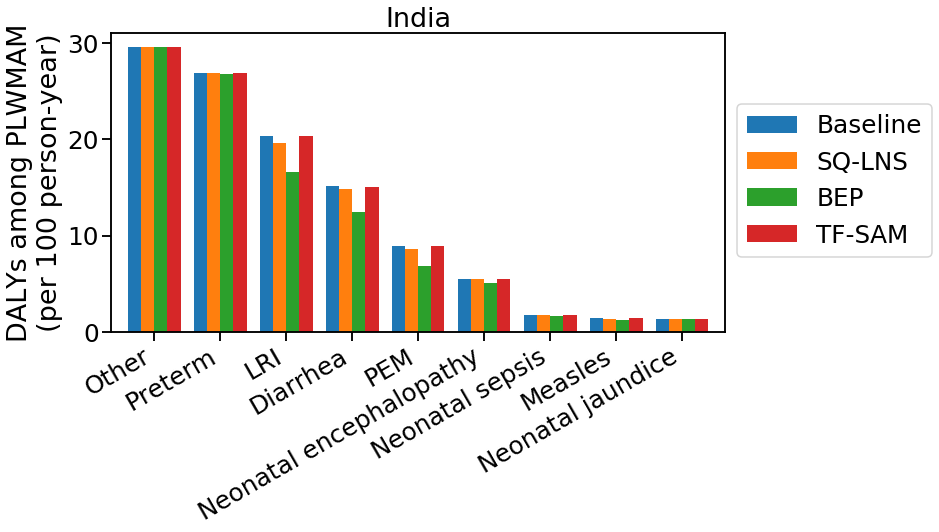

In [82]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'dalys')].astype(float)/1_000)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs among PLWMAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
    plt.title(country)
my_plot('India', cols_to_blank=[])

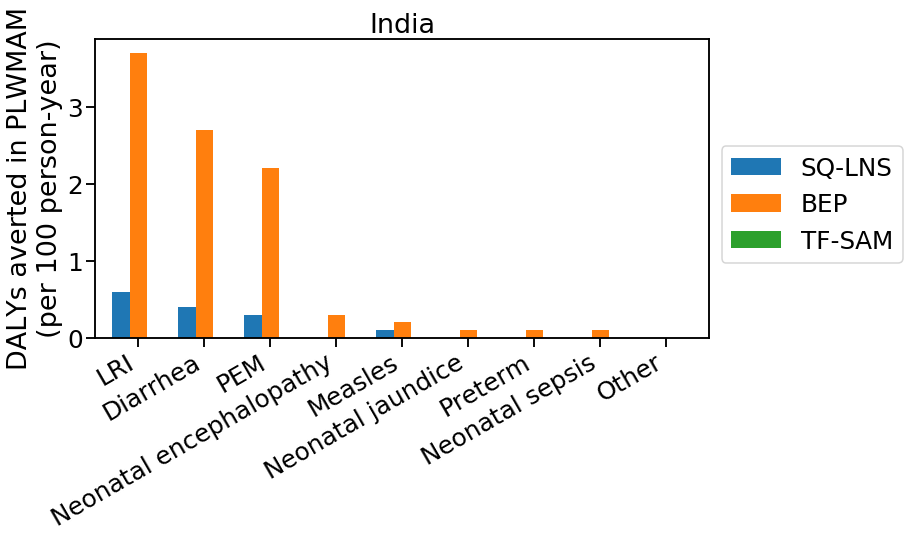

In [83]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'dalys_averted')].astype(float)/1_000)\
        .filter(['sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('BEP', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs averted in PLWMAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
    plt.axis(ymin=0)
    plt.title(country)
my_plot('India', cols_to_blank=[])

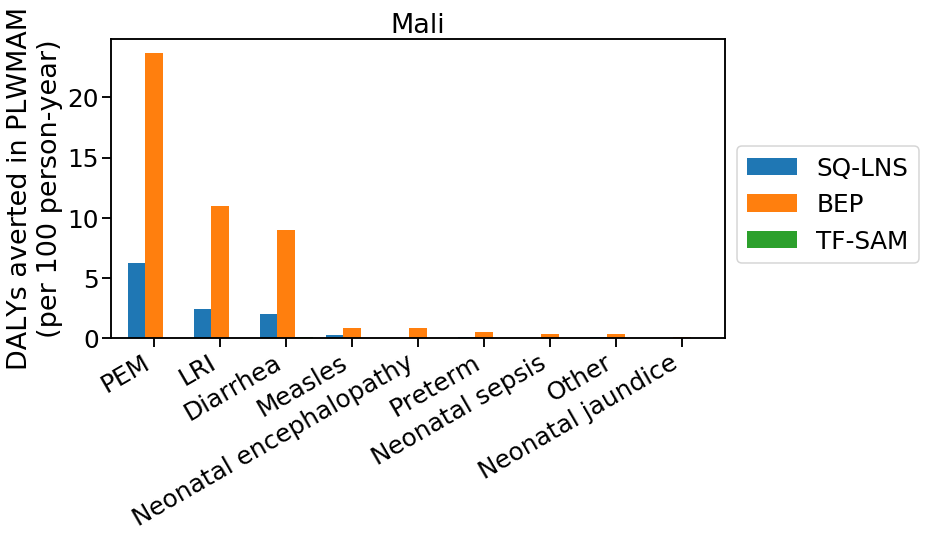

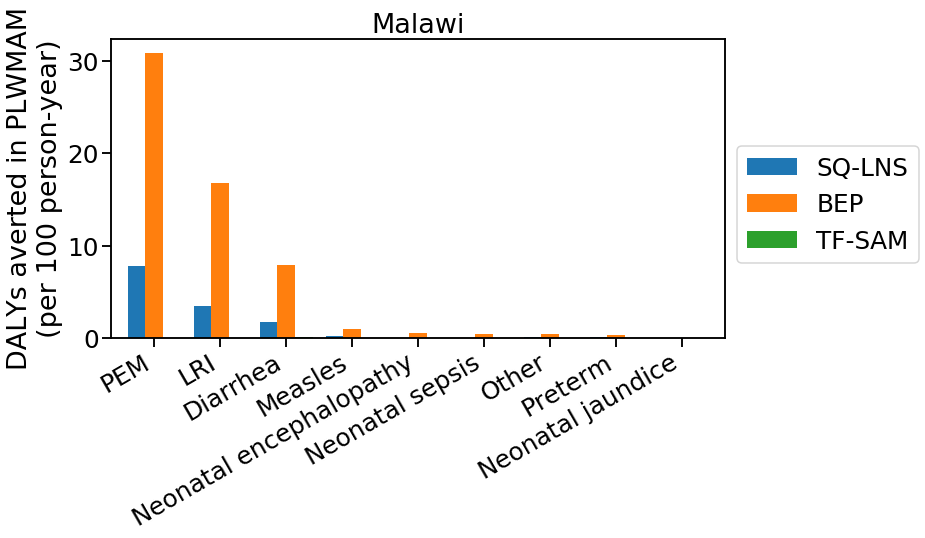

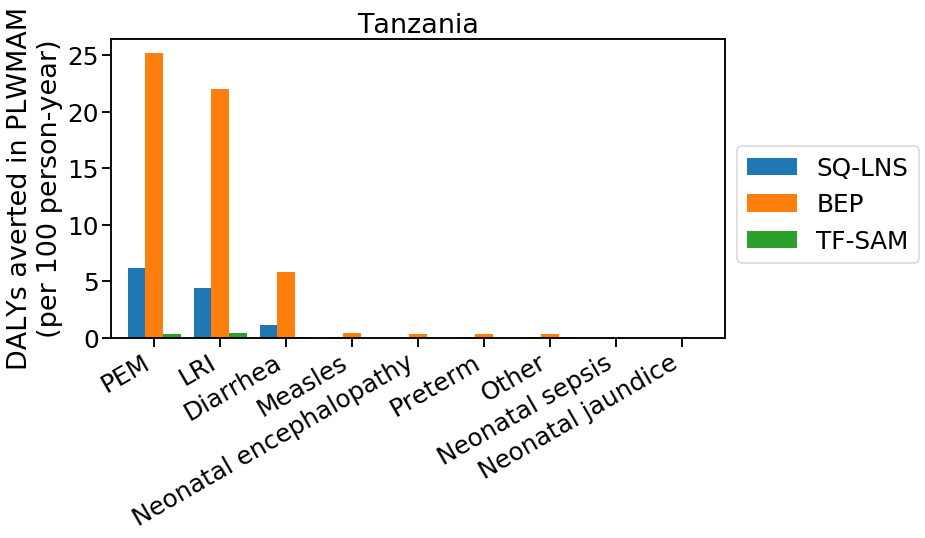

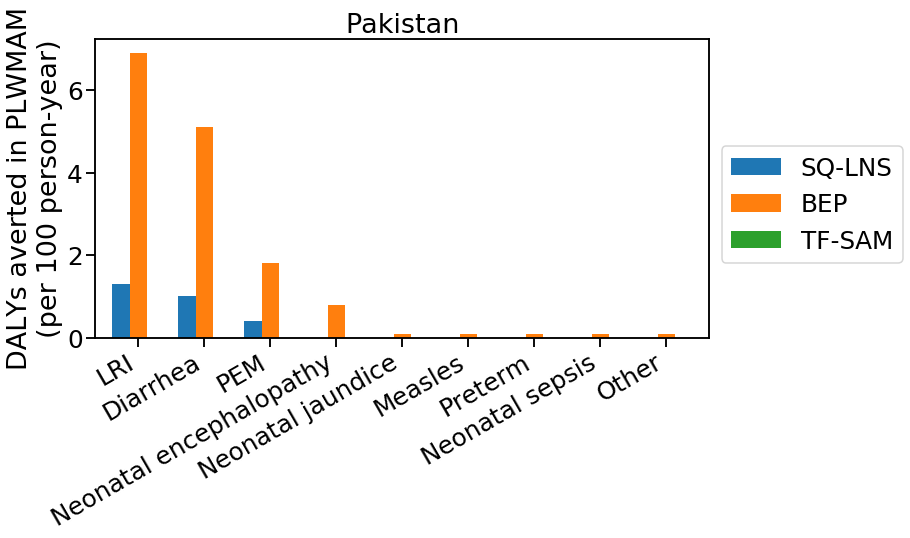

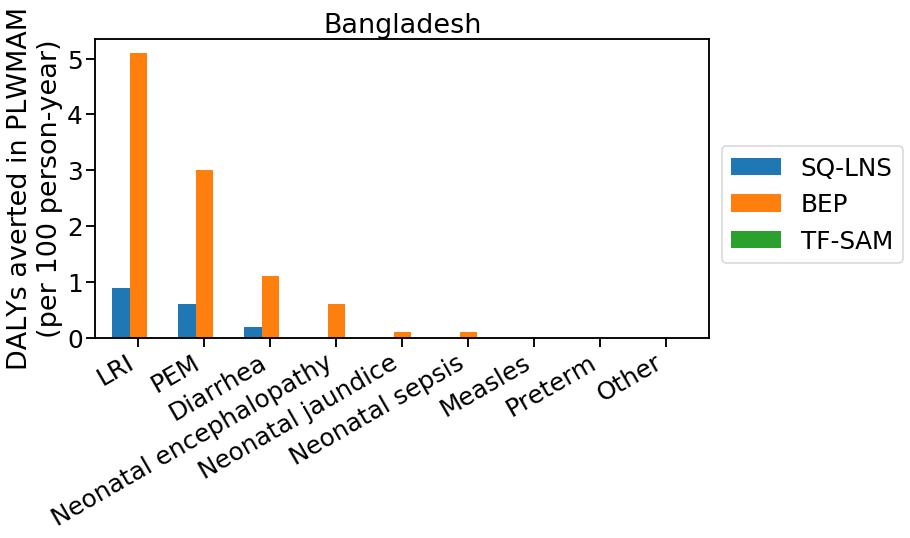

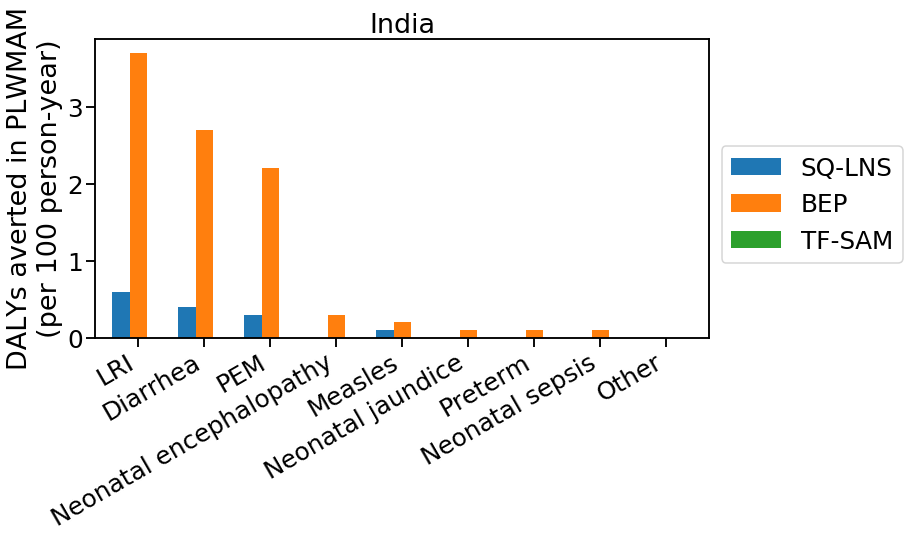

In [84]:
for location in location_list[::-1]:
    my_plot(location)

In [85]:
cause_specific_dalys_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,2700,400,0
Bangladesh,diarrheal_diseases,1100,200,0
Pakistan,diarrheal_diseases,5100,1000,0
Tanzania,diarrheal_diseases,5800,1100,100
Malawi,diarrheal_diseases,7900,1700,100
Mali,diarrheal_diseases,9000,2000,100


In [86]:
cause_specific_dalys_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,3700,600,0
Bangladesh,lower_respiratory_infections,5100,900,0
Pakistan,lower_respiratory_infections,6900,1300,0
Tanzania,lower_respiratory_infections,22000,4400,400
Malawi,lower_respiratory_infections,16800,3500,0
Mali,lower_respiratory_infections,11000,2400,0


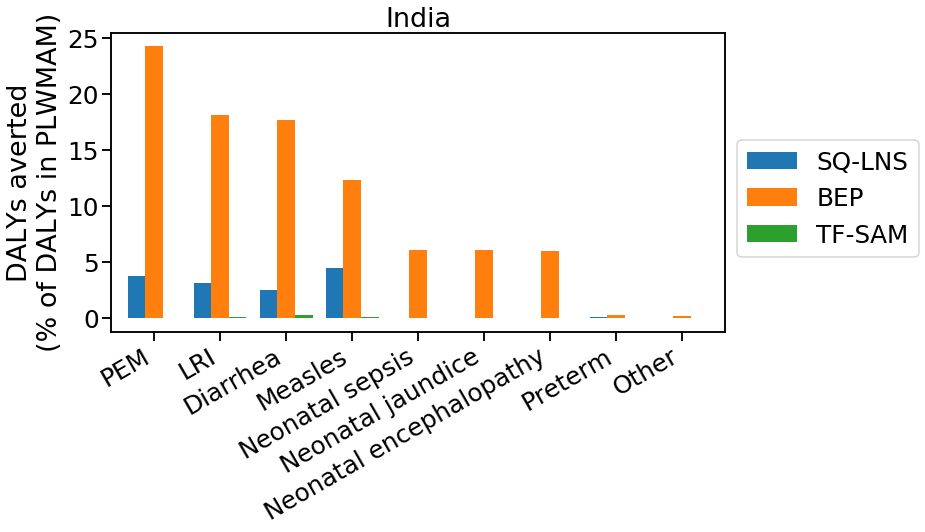

In [87]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'pct_averted')].astype(float))\
        .filter(['sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('BEP', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs averted\n(% of DALYs in PLWMAM)')
    plt.xticks(rotation=30, ha='right')
    plt.title(country)
my_plot('India', cols_to_blank=[])

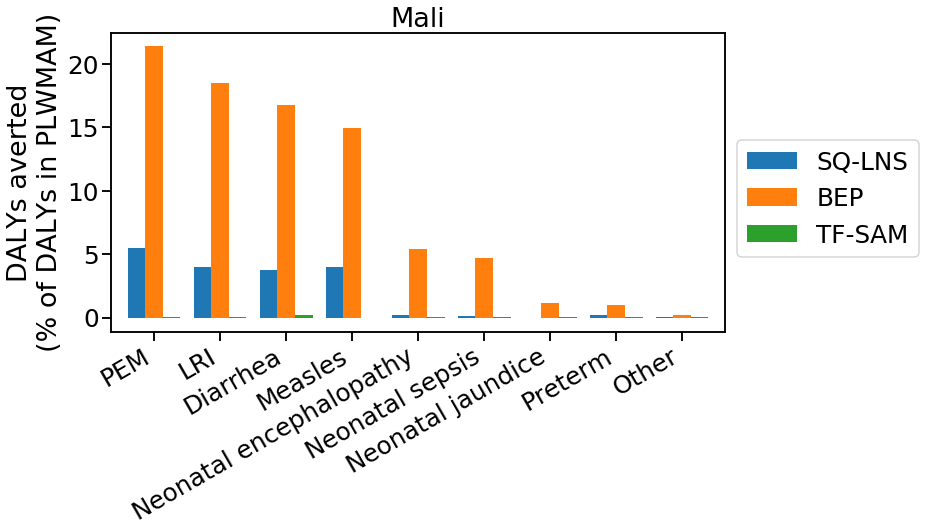

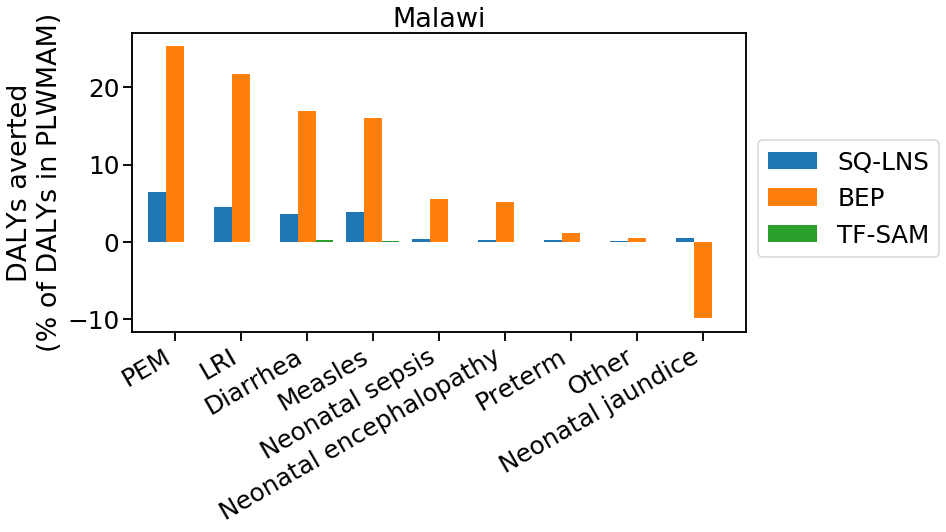

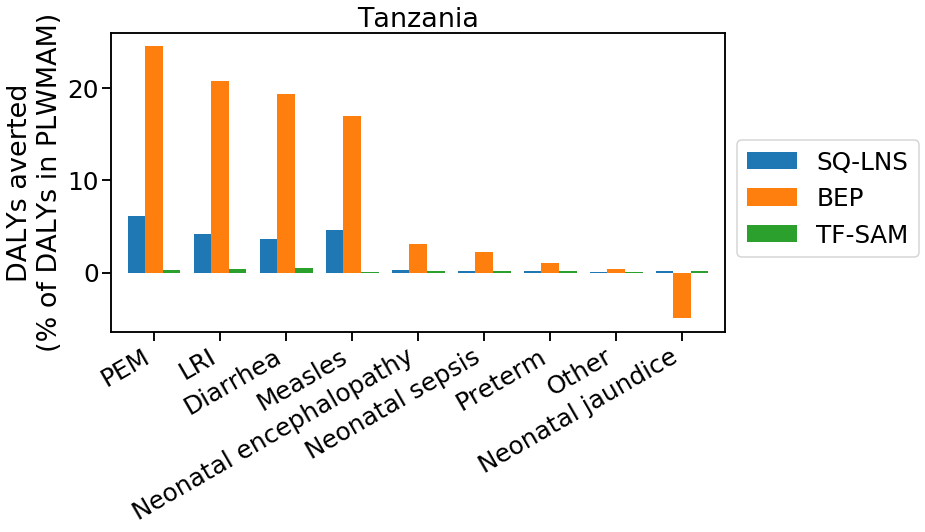

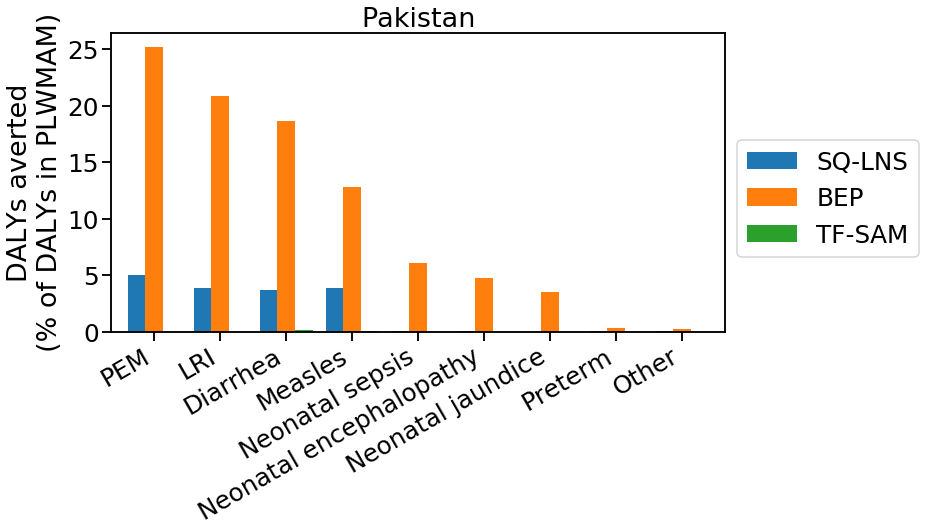

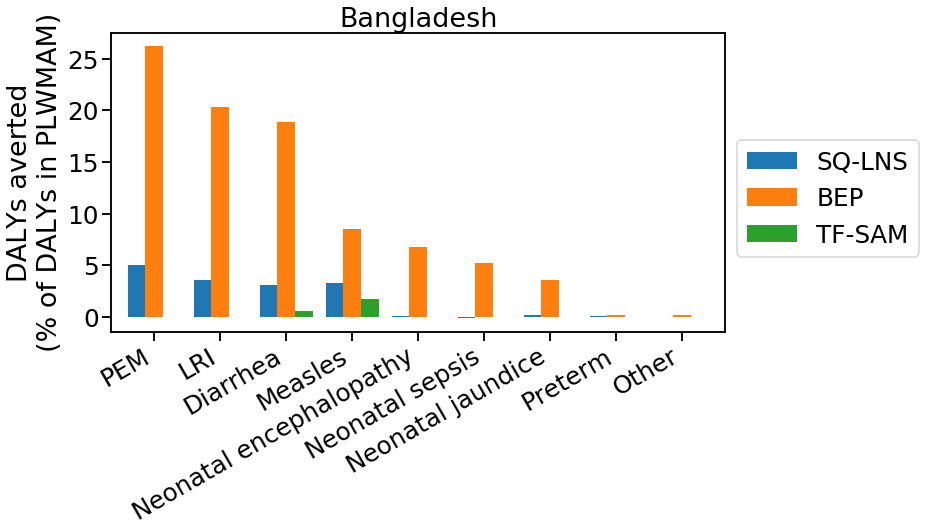

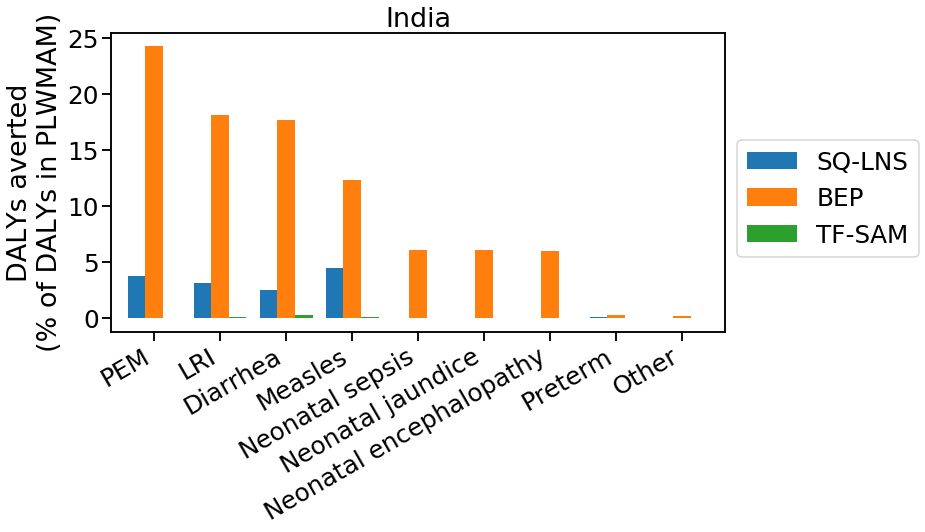

In [88]:
for location in location_list[::-1]:
    my_plot(location)

In [89]:
cause_specific_pct_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,17.71,2.45,0.26
Bangladesh,diarrheal_diseases,18.86,3.06,0.57
Pakistan,diarrheal_diseases,18.69,3.66,0.18
Tanzania,diarrheal_diseases,19.40,3.67,0.52
Malawi,diarrheal_diseases,16.87,3.58,0.20
Mali,diarrheal_diseases,16.77,3.77,0.17


In [90]:
cause_specific_pct_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,18.09,3.14,0.07
Bangladesh,lower_respiratory_infections,20.38,3.61,0.01
Pakistan,lower_respiratory_infections,20.84,3.84,0.02
Tanzania,lower_respiratory_infections,20.82,4.21,0.40
Malawi,lower_respiratory_infections,21.71,4.52,0.06
Mali,lower_respiratory_infections,18.45,3.95,0.07


In [91]:
cause_specific_pct_by_location('neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma')

,,bep,sqlns,tfsam
India,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.97,0.01,0.03
Bangladesh,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,6.74,0.06,0.00
Pakistan,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,4.77,0.08,0.01
Tanzania,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,3.11,0.30,0.12
Malawi,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.18,0.32,0.03
Mali,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.38,0.20,0.04


In [92]:
df['Pakistan'].filter(like='encepha').T

interventions.BEP_intervention.coverage_proportion              0.0  \
interventions.SQ_LNS_intervention.coverage_proportion           0.0   
interventions.TF_SAM_intervention.coverage_proportion           0.0   
input_draw_number                                             8.0     
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       625.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       135.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       306.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        57.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      2231.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         0.000000   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       145.701317   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       171.883464   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        81.422069   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       164.026989   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        18.752720   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     54893.902857   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     11860.823427   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     26885.028646   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      5008.273420   

interventions.BEP_intervention.coverage_proportion                   \
interventions.SQ_LNS_intervention.coverage_proportion                 
interventions.TF_SAM_intervention.coverage_proportion                 
input_draw_number                                             21.0    
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       613.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       111.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       199.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        45.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      1663.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         0.000000   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        76.957730   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       273.900310   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        89.084625   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       112.177733   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        15.492670   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     53836.346582   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      9753.293387   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     17477.365605   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      3954.416144   

interventions.BEP_intervention.coverage_proportion                   \
interventions.SQ_LNS_intervention.coverage_proportion                 
interventions.TF_SAM_intervention.coverage_proportion                 
input_draw_number                                             29.0    
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       609.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        92.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       191.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        53.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      1737.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopath

In [93]:
country = 'India'
key = f'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_{cat}'
t = df[country].loc[:,
    key].unstack().T
t # I expect the first three colunms to be the same

interventions.BEP_intervention.coverage_proportion      0.0               0.8
interventions.SQ_LNS_intervention.coverage_proportion   0.0         0.8   0.0
interventions.TF_SAM_intervention.coverage_proportion   0.0   0.8   0.0   0.0
input_draw_number                                                            
8.0                                                    38.0  38.0  38.0  37.0
21.0                                                   31.0  31.0  31.0  28.0
29.0                                                   45.0  45.0  45.0  40.0
30.0                                                   36.0  36.0  36.0  30.0
36.0                                                   26.0  26.0  26.0  25.0
...                                                     ...   ...   ...   ...
954.0                                                  47.0  47.0  47.0  46.0
956.0                                                  43.0  43.0  43.0  40.0
983.0                                                  30.0  30.0  30.0  27.0
990.0                                                  28.0  28.0  28.0  26.0
998.0                                                  33.0  33.0  33.0  29.0

[100 rows x 4 columns]

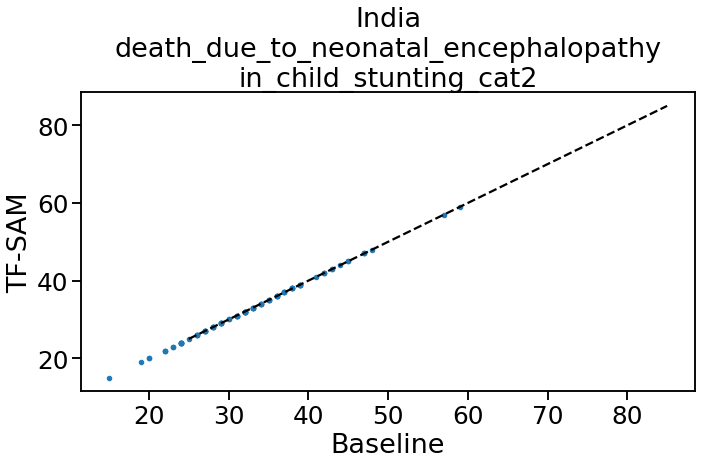

In [94]:
plt.plot(t.iloc[:,0], t.iloc[:,1], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('TF-SAM')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

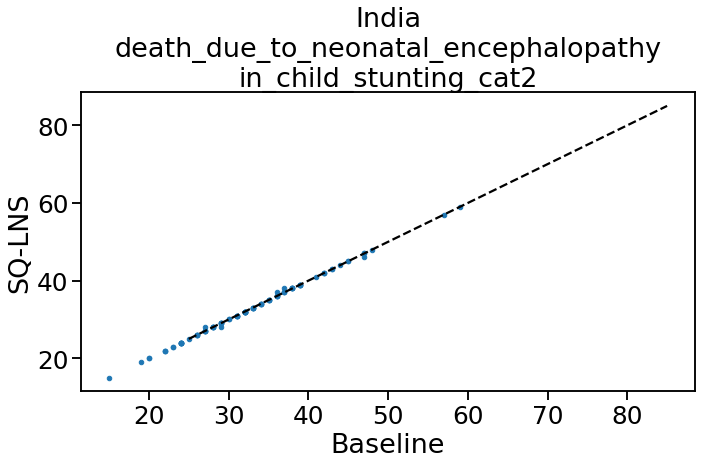

In [95]:
plt.plot(t.iloc[:,0], t.iloc[:,2], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('SQ-LNS')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

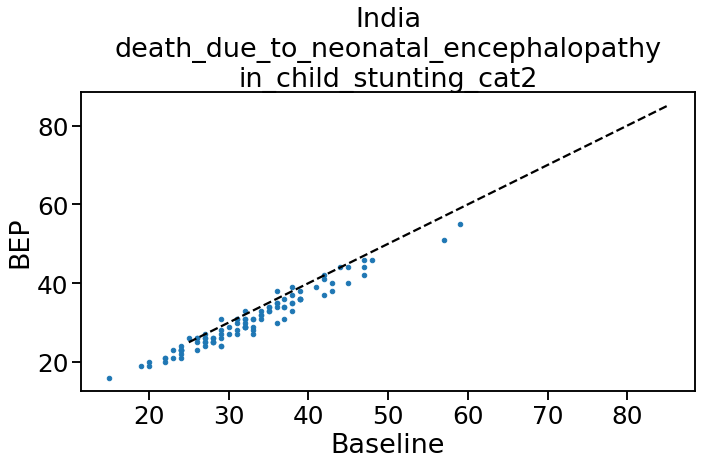

In [96]:
plt.plot(t.iloc[:,0], t.iloc[:,3], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('BEP')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

In [97]:
#MCVE
t = pd.read_hdf('vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf')

del t['random_seed']
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]
g = t.reset_index().groupby(scenarios + ['input_draw_number', 'random_seed'])
t = g.first()
    
key = f'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_{cat}'
t.loc[:,key].unstack().unstack().T

interventions.BEP_intervention.coverage_proportion      0.0               0.8
interventions.SQ_LNS_intervention.coverage_proportion   0.0         0.8   0.0
interventions.TF_SAM_intervention.coverage_proportion   0.0   0.8   0.0   0.0
random_seed input_draw_number                                                
0.0         8.0                                        11.0  11.0  11.0  10.0
            21.0                                       14.0  14.0  14.0  14.0
            29.0                                        9.0   9.0   9.0   9.0
            30.0                                       11.0  11.0  11.0  10.0
            36.0                                       12.0  12.0  12.0  12.0
...                                                     ...   ...   ...   ...
97.0        954.0                                       7.0   7.0   7.0   6.0
            956.0                                       9.0   9.0   9.0   9.0
            983.0                                      14.0  14.0  14.0  14.0
            990.0                                      11.0  11.0  11.0  11.0
            998.0                                       6.0   6.0   6.0   6.0

[1000 rows x 4 columns]

In [98]:
# missing some entries, but there are still jobs running
# what about India?

In [99]:
#MCVE
t = pd.read_hdf('vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf')

del t['random_seed']
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]
g = t.reset_index().groupby(scenarios + ['input_draw_number', 'random_seed'])
t = g.first()
    
key = f'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_{cat}'
t.loc[:,key].unstack().unstack().T

interventions.BEP_intervention.coverage_proportion      0.0               0.8
interventions.SQ_LNS_intervention.coverage_proportion   0.0         0.8   0.0
interventions.TF_SAM_intervention.coverage_proportion   0.0   0.8   0.0   0.0
random_seed input_draw_number                                                
0.0         8.0                                        10.0  10.0  10.0  10.0
            21.0                                        5.0   5.0   5.0   3.0
            29.0                                        7.0   7.0   7.0   6.0
            30.0                                        1.0   1.0   1.0   1.0
            36.0                                        1.0   1.0   1.0   1.0
...                                                     ...   ...   ...   ...
97.0        954.0                                       7.0   7.0   7.0   7.0
            956.0                                       2.0   2.0   2.0   2.0
            983.0                                       4.0   4.0   4.0   4.0
            990.0                                       5.0   5.0   5.0   5.0
            998.0                                       4.0   4.0   4.0   2.0

[1000 rows x 4 columns]